<a href="https://colab.research.google.com/github/yangjiwoong1/AIFFEL_quest_rs/blob/main/GoingDeeper/Quest03/class_activation_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

## 데이터 로드

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.SBYNFT_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.SBYNFT_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


## 데이터 전처리 함수 정의 및 파이프라인 정의

In [3]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [4]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


## CAM 모델 학습
- 해당 모델을 기준으로 기본 CAM과 Grad-CAM을 진행

In [9]:
def build_cam_model(num_classes, fine_tunning = False):
  base_model = keras.applications.resnet50.ResNet50(
      include_top=False,    # Imagenet 분류기  fully connected layer 제거
      weights='imagenet',
      input_shape=(224, 224, 3),
      pooling='avg',      # GAP를 적용
  )

  if fine_tunning:
    for layer in base_model.layers:
      layer.trainable = False

  x = base_model.output
  preds = keras.layers.Dense(num_classes, tf.nn.softmax, use_bias=False)(x)
  cam_model = keras.Model(inputs=base_model.input, outputs=preds)

  return cam_model

In [10]:
num_classes = ds_info.features["label"].num_classes
cam_model = build_cam_model(num_classes)
cam_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,833,472 (90.92 MB)

 Trainable params: 23,780,352 (90.71 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [11]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [12]:
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath = '/content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_quest_rs/GoingDeeper/Quest03/cam_model_no_finetunning.keras',
    monitor="val_loss",
    save_best_only=True
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=4,
    validation_data=ds_val_norm,
    verbose=1,
    callbacks=[model_checkpoint_cb]
)

Epoch 1/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 165s 187ms/step - accuracy: 0.2761 - loss: 3.2090 - val_accuracy: 0.1955 - val_loss: 3.4612
Epoch 2/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 134s 179ms/step - accuracy: 0.7615 - loss: 0.8629 - val_accuracy: 0.5826 - val_loss: 1.4453
Epoch 3/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 204s 262ms/step - accuracy: 0.9564 - loss: 0.2396 - val_accuracy: 0.6622 - val_loss: 1.1761
Epoch 4/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 134s 179ms/step - accuracy: 0.9880 - loss: 0.1080 - val_accuracy: 0.7094 - val_loss: 1.0377


## CAM, Grad-CAM 생성 함수 정의

In [13]:
# 데이터 샘플 1개를 가져오는 함수
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [14]:
# CAM
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    img_tensor, class_idx = normalize_and_resize_img(item)

    # model.output은 출력층 가중치를 가져오기 위해 출력
    cam_model = tf.keras.models.Model(inputs = model.inputs, outputs = [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0)) # 배치 차원 추가
    conv_outputs = conv_outputs[0, :, :, :] # 배치 차원 제거

    # 출력층 가중치를 가져옴(bias 제외)
    class_weights = model.layers[-1].get_weights()[0] # [kernel_weights, bias_weights]

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # 활성화 맵 계산
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize
    return cam_image

In [15]:
# Grad-CAM
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))

        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값
        output = conv_output[0] # 원하는 layer의 output
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구함
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻음
        grad_cam_image += w * output[:, :, k]

    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

## CAM, Grad-CAM 적용

In [27]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

적용할 이미지

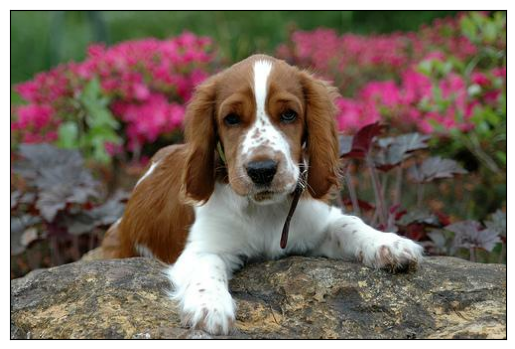

In [28]:
item = get_one(ds_test)
item_image = item['image']
item_label = item['label']
item_bbox = item['objects']['bbox']

plt.xticks([])
plt.yticks([])

plt.imshow(item_image)

CAM

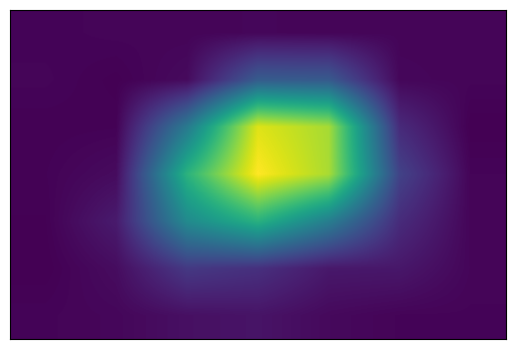

In [29]:
cam_image = generate_cam(cam_model, item)

plt.xticks([])
plt.yticks([])

plt.imshow(cam_image)

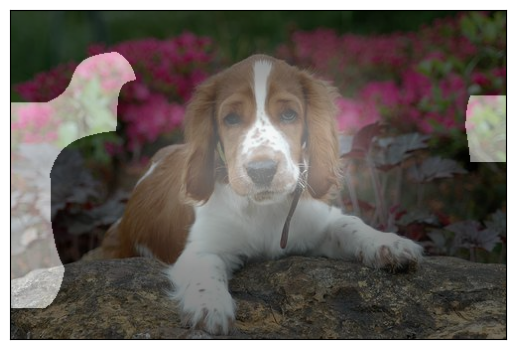

In [30]:
origin_image = item_image.astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)

plt.xticks([])
plt.yticks([])

plt.imshow(blended_image)

Grad-CAM

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_177']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


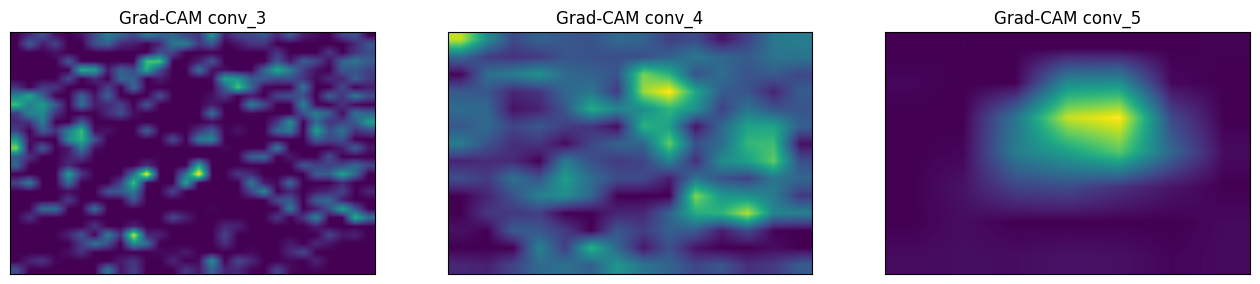

In [31]:
grad_cam_image_conv3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
grad_cam_image_conv4 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
grad_cam_image_conv5 = generate_grad_cam(cam_model, 'conv5_block3_out', item)

grad_cam_images = [grad_cam_image_conv3, grad_cam_image_conv4, grad_cam_image_conv5]
plt.figure(figsize=(16,8))
for i in range(1):
  for j in range(3):
    plt.subplot(1, 3, j + 1)
    plt.imshow(grad_cam_images[j])

    plt.xticks([])
    plt.yticks([])

    plt.title(f'Grad-CAM conv_{j+3}')

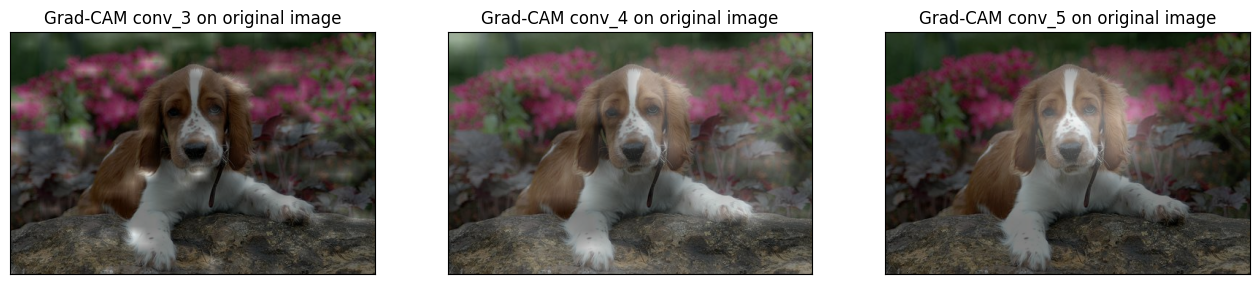

In [32]:
plt.figure(figsize=(16,8))
for i in range(1):
  for j in range(3):
    cam_image_3channel = np.stack([grad_cam_images[j]*255]*3, axis=-1).astype(np.uint8)
    blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)

    plt.subplot(1, 3, j + 1)
    plt.imshow(blended_image)

    plt.xticks([])
    plt.yticks([])

    plt.title(f'Grad-CAM conv_{j+3} on original image')

### 바운딩 박스 구하고 시각화 및 IoU 출력

In [33]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)

    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int32(rect)
    return rect

In [34]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다.
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return np.array(bbox, dtype='float32')

In [35]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])

    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

CAM

IoU score: 0.675740122795105


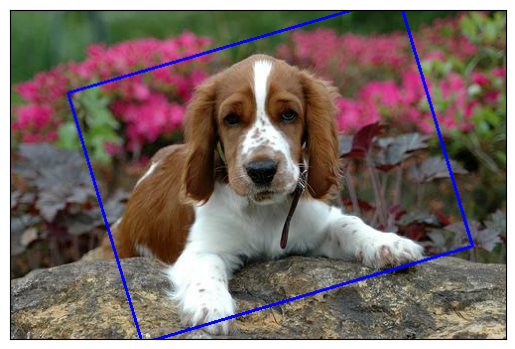

In [36]:
rect = get_bbox(cam_image)

image = copy.deepcopy(item_image)
cv2.drawContours(image, [rect], 0, (0,0,255), 2)

plt.xticks([])
plt.yticks([])

plt.imshow(image)

pred_bbox = rect_to_minmax(rect, item['image'])
print(f"IoU score: {get_iou(pred_bbox, item['objects']['bbox'][0])}")

Grad-CAM

IoU score: 0.575738787651062
IoU score: 0.582554817199707
IoU score: 0.5660544633865356


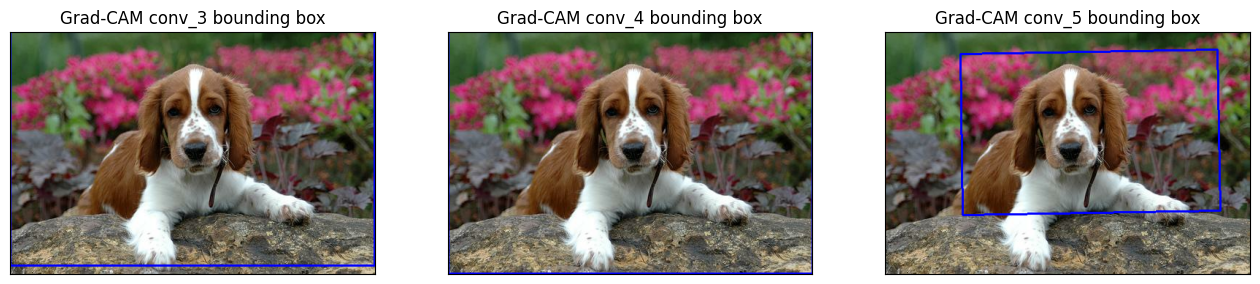

In [37]:
plt.figure(figsize=(16,8))
for i in range(1):
  for j in range(3):
    rect = get_bbox(grad_cam_images[j])

    image = copy.deepcopy(item_image)
    cv2.drawContours(image, [rect], 0, (0,0,255), 2)
    cv2.drawContours(image, [rect], 0, (0,0,255), 2)

    plt.subplot(1, 3, j + 1)
    plt.imshow(image)

    plt.xticks([])
    plt.yticks([])

    plt.title(f'Grad-CAM conv_{j+3} bounding box')

    pred_bbox = rect_to_minmax(rect, item['image'])
    print(f"IoU score: {get_iou(pred_bbox, item['objects']['bbox'][0])}")

회고
- IoU 점수가 Grad-CAM이 더 낮게 나온 것이 타당한지에 대한 분석이 필요할 거 같다.
- 원본이미지와 CAM 결과를 블렌딩한 부분에서 가장자리도 강조가됐는데 이에 대한 분석이 필요할 거 같다.